# Womenswear Price Prediction Model

### Problem Statement:

As the fashion industry continues to evolve with many new players entering the market, it is interesting to understand what are some of the features that could lead to a slight price differentiation between brands. This could help new entrants to determine where they should be pricing their products to gain a competitive edge.

This model aims to provide the "right pricing" for any given item of clothing, depending on its brand, category as well as descriptions provided by the seller.

In [629]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from math import radians, sin, cos, axsin, sqrt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score,mean_squared_error
from scipy.sparse import csr_matrix, hstack
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline
pd.set_option('display.max_columns',500)
pd.options.display.max_colwidth = 400

## Merging Datasets and Clean Up

In [630]:
asos = pd.read_csv("asos.csv")
zalora = pd.read_csv("zalora.csv")
hm = pd.read_csv("hnm.csv")
zara=pd.read_csv("zara.csv")
rb = pd.read_csv("rb.csv")
osn = pd.read_csv("osn.csv")
lb = pd.read_csv("lb_clean.csv")
asos_jeans = pd.read_csv("asos_jeans.csv")
asos_trousers = pd.read_csv("asos_trousers.csv")
# asos_lingerie = pd.read_csv("asos_lingerie.csv")


In [631]:
asos.drop(columns=['Unnamed: 0'], inplace=True)
asos.columns

Index(['name', 'price', 'colour', 'description', 'about_me', 'brand',
       'category'],
      dtype='object')

In [632]:
zalora.drop(columns=['Unnamed: 0'], inplace=True)
zalora.columns

Index(['brand', 'title', 'price', 'description', 'colour', 'category'], dtype='object')

In [633]:
zara.drop(columns=['Unnamed: 0'], inplace=True)
zara.columns

Index(['title', 'price', 'colour', 'description', 'category', 'brand'], dtype='object')

In [634]:
rb.drop(columns=['Unnamed: 0'], inplace=True)
rb.columns

Index(['title', 'price', 'brand', 'description', 'colour', 'category'], dtype='object')

In [635]:
osn.drop(columns=['Unnamed: 0'], inplace=True)
osn.columns

Index(['brand', 'title', 'price', 'description', 'material', 'colour',
       'category'],
      dtype='object')

In [636]:
hm.drop(columns=['Unnamed: 0'], inplace=True)
hm['brand'] = 'H&M'
hm.columns

Index(['title', 'price', 'description', 'colour', 'category', 'brand'], dtype='object')

In [637]:
lb.drop(columns=['Unnamed: 0'], inplace=True)
lb.columns

Index(['title', 'price', 'colour', 'category', 'description', 'brand'], dtype='object')

In [638]:
asos_jeans.drop(columns=['Unnamed: 0'], inplace=True)
asos_jeans.columns

Index(['title', 'brand', 'price', 'description', 'colour', 'category'], dtype='object')

In [639]:
asos_trousers.drop(columns=['Unnamed: 0'], inplace=True)
asos_trousers.columns

Index(['title', 'brand', 'price', 'description', 'colour', 'category'], dtype='object')

In [640]:
asos['full_description'] = asos['description'] + ' ' + asos['about_me']
asos.drop(columns=['about_me', 'description'],inplace=True)
asos.head()

,name,price,colour,brand,category,full_description
0,& Other Stories velvet jacquard ruched mini skirt in black,101.90,Black,& Other Stories,skirts,"Coming soon to your Saved Items Stretch waistband Ruched design Ruffled hem Bodycon fit A tight cut to the body Velvet jacquard Drapey fabric with an intricate, interwoven pattern Main: 95% Polyester, 5% Elastane."
1,ASOS DESIGN neon boucle suit skirt,55.58,Check,ASOS DESIGN,skirts,"For your daytime thing Check design High-rise waist Zip-side fastening Slim fit Cut close to the body Textured boucléLooped fabric with a woolly finish Body: 68% Acrylic, 25% Polyester, 7% Viscose, Lining: 100% Polyester."
2,Liquorish pleated midaxi skirt in pink neon colour block,101.90,Pink,Liquorish,skirts,For that thing you have to go to Pleated design High rise Stretch waistband Midi length Regular fit Just select your usual size Smooth woven fabric It's light and floaty Fabric: 100% Polyester.
3,Vila faux leather skirt,55.58,Black,Vila,skirts,"Add-to-bag potential: considerable High-rise waist Kick split Zip-back fastening Regular fit Just select your usual size Faux leather Looks like real leather, but it's not Pointing out the obvious Body: 100% Polyester."
4,People Tree velvet mini skirt,120.43,Black,People Tree,skirts,Easily dressed up or down High-rise waist Button detail Regular fit Just select your usual size Soft velvet One smooth operator Body: 100% Cotton.


In [641]:
asos.rename(columns={'full_description':'description','name':'title'},inplace=True)
asos.head()

,title,price,colour,brand,category,description
0,& Other Stories velvet jacquard ruched mini skirt in black,101.90,Black,& Other Stories,skirts,"Coming soon to your Saved Items Stretch waistband Ruched design Ruffled hem Bodycon fit A tight cut to the body Velvet jacquard Drapey fabric with an intricate, interwoven pattern Main: 95% Polyester, 5% Elastane."
1,ASOS DESIGN neon boucle suit skirt,55.58,Check,ASOS DESIGN,skirts,"For your daytime thing Check design High-rise waist Zip-side fastening Slim fit Cut close to the body Textured boucléLooped fabric with a woolly finish Body: 68% Acrylic, 25% Polyester, 7% Viscose, Lining: 100% Polyester."
2,Liquorish pleated midaxi skirt in pink neon colour block,101.90,Pink,Liquorish,skirts,For that thing you have to go to Pleated design High rise Stretch waistband Midi length Regular fit Just select your usual size Smooth woven fabric It's light and floaty Fabric: 100% Polyester.
3,Vila faux leather skirt,55.58,Black,Vila,skirts,"Add-to-bag potential: considerable High-rise waist Kick split Zip-back fastening Regular fit Just select your usual size Faux leather Looks like real leather, but it's not Pointing out the obvious Body: 100% Polyester."
4,People Tree velvet mini skirt,120.43,Black,People Tree,skirts,Easily dressed up or down High-rise waist Button detail Regular fit Just select your usual size Soft velvet One smooth operator Body: 100% Cotton.


In [642]:
df = pd.concat([zalora,asos,hm,zara,rb,lb,asos_jeans,asos_trousers,asos_lingerie])
df = df.reset_index(drop=True)
df.head()

/Users/lynn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,brand,category,colour,description,price,title
0,Kodz,jumpsuits,Khaki,Slouchy short sleeves jumpsuit with waist tie Round neckline Regular fit Zip fastening 2 pockets Polyblend,64.9,Square Neck Tie Waist Jumpsuit
1,Kodz,jumpsuits,Green,Solid hue strappy wrap jumpsuit V neckline Regular fit Elasticized waistband 2 side pockets Sleeveless Tapered legs Polyester blend,54.9,Cross Front Jumpsuit
2,Kodz,jumpsuits,Apricot,Buttoned jumpsuit with stripes Notch lapels Regular fit Front button fastening Self tie waist closure 2 side pockets Sleeveless Wide legs Polyester,59.9,Belted Button Front Jumpsuit
3,Finders Keepers,jumpsuits,Black,Solid tone front twist strapless jumpsuit Bandeau neckline Unlined Regular fit Back zip fastening Polyblend,237.9,Elena Jumpsuit
4,ZALORA BASICS,jumpsuits,Khaki,Solid hue playsuit with rope detail Notch lapels Regular fit Side zip fastening Self tie waist closure Short sleeves Polyester,34.9,Basic Rope Tie Resort Playsuit


Text(0.5, 1.0, 'Price Distribution')

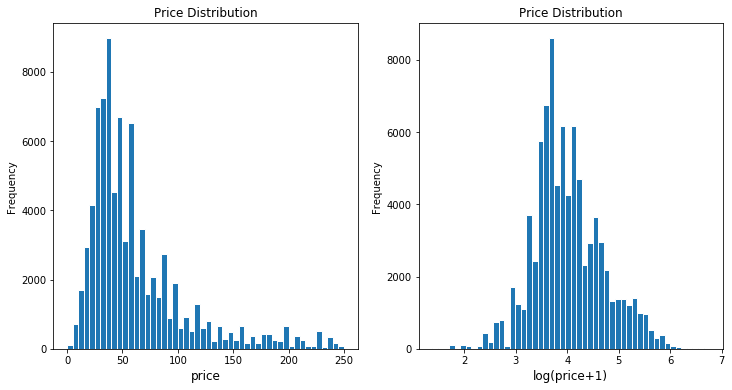

In [643]:
plt.subplot(1, 2, 1)
(df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)


In [644]:
df.head()

,brand,category,colour,description,price,title
0,Kodz,jumpsuits,Khaki,Slouchy short sleeves jumpsuit with waist tie Round neckline Regular fit Zip fastening 2 pockets Polyblend,64.9,Square Neck Tie Waist Jumpsuit
1,Kodz,jumpsuits,Green,Solid hue strappy wrap jumpsuit V neckline Regular fit Elasticized waistband 2 side pockets Sleeveless Tapered legs Polyester blend,54.9,Cross Front Jumpsuit
2,Kodz,jumpsuits,Apricot,Buttoned jumpsuit with stripes Notch lapels Regular fit Front button fastening Self tie waist closure 2 side pockets Sleeveless Wide legs Polyester,59.9,Belted Button Front Jumpsuit
3,Finders Keepers,jumpsuits,Black,Solid tone front twist strapless jumpsuit Bandeau neckline Unlined Regular fit Back zip fastening Polyblend,237.9,Elena Jumpsuit
4,ZALORA BASICS,jumpsuits,Khaki,Solid hue playsuit with rope detail Notch lapels Regular fit Side zip fastening Self tie waist closure Short sleeves Polyester,34.9,Basic Rope Tie Resort Playsuit


In [645]:
df.shape

(84021, 6)

In [646]:
df.dtypes

brand           object
category        object
colour          object
description     object
price          float64
title           object
dtype: object

In [647]:
df.isnull().sum()

brand            0
category         0
colour           1
description    143
price            1
title            0
dtype: int64

In [648]:
df['category'] = df['category'].str.lower()

In [649]:
df['category'].unique()

array(['jumpsuits', 'pants', 'skirts', 'dresses', 'shorts', 'jackets',
       'blazers', 'jeans', 'cardigans', 'hoodies', 'tops', 'bottoms',
       'outerwear', 'loungewear', 'dress', 'lingerie', 'plus size',
       'jumpsuit', 'maternity', 'activewear', 'basics'], dtype=object)

In [650]:
for row in range(df.shape[0]):
    if 'jumpsuit' in df['category'][row]:
        df.loc[row,'category'] = 'jumpsuits'
    elif 'jackets' in df['category'][row]:
        df.loc[row,'category'] = 'outerwear'
    elif 'blazers' in df['category'][row]:
        df.loc[row,'category'] = 'outerwear'
    elif 'cardigan' in df['category'][row]:
        df.loc[row,'category'] = 'outerwear'
    elif 'hoodies' in df['category'][row]:
        df.loc[row,'category'] = 'outerwear'
    elif 'dress' in df['category'][row]:
        df.loc[row,'category'] = 'dresses'
    elif 'pants' in df['category'][row]:
        df.loc[row,'category'] = 'bottoms'

        

In [651]:
df['category'].nunique()

14

In [652]:
df['category'].unique()

array(['jumpsuits', 'bottoms', 'skirts', 'dresses', 'shorts', 'outerwear',
       'jeans', 'tops', 'loungewear', 'lingerie', 'plus size',
       'maternity', 'activewear', 'basics'], dtype=object)

In [653]:
# category_tofix = []
# categories = ['tops','dress','skirts','outerwear','bottoms','jumpsuits','shorts','jeans']
# for category in df['category'].unique():
#     if category not in categories:
#         category_tofix.append(category)

# for row in range(df.shape[0]):
#         if df['category'][row] not in category_tofix:
#             df.drop(row,inplace=True)

In [654]:
categories = ['tops','dresses','skirts','outerwear','bottoms','shorts','jeans','lingerie','loungewear']
for row in range(df.shape[0]):
        if df['category'][row] not in categories:
            df.drop(row,inplace=True)

In [655]:
df.groupby('category')['price'].count().sort_values(ascending=False)

category
tops          18267
dresses       13980
outerwear     13102
skirts        10873
bottoms       10638
shorts         4916
jeans          3976
lingerie       2736
loungewear      644
Name: price, dtype: int64

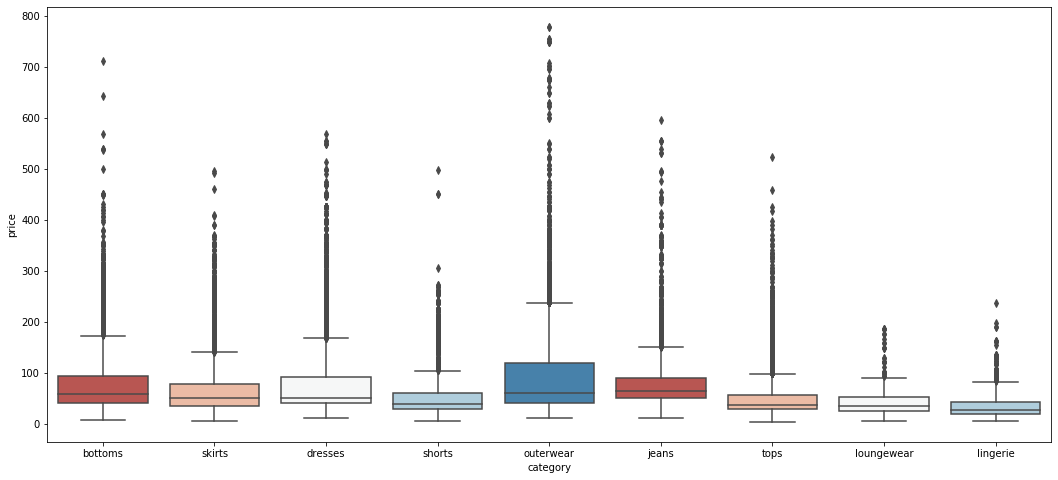

In [656]:
tops = df.loc[(df['category']=='tops'), 'price']
dresses = df.loc[(df['category'] == 'dresses'), 'price']
outerwear = df.loc[(df['category'] == 'outerwear'), 'price']
skirts = df.loc[(df['category'] == 'skirts'), 'price']
bottoms = df.loc[(df['category'] == 'bottoms'), 'price']
shorts = df.loc[(df['category'] == 'shorts'), 'price']
jumpsuits = df.loc[(df['category'] == 'jumpsuits'), 'price']
jeans = df.loc[(df['category'] == 'jeans'), 'price']
lingerie = df.loc[(df['category'] == 'lingerie'), 'price']
loungewear = df.loc[(df['category'] == 'loungewear'), 'price']


fig, ax = plt.subplots(figsize=(18,8))

sns.boxplot(x = 'category', y = df.price, data = df, palette = sns.color_palette('RdBu',5))


In [657]:
df.columns

Index(['brand', 'category', 'colour', 'description', 'price', 'title'], dtype='object')

In [658]:
df.shape

(79133, 6)

In [659]:
df['category'].unique()

array(['bottoms', 'skirts', 'dresses', 'shorts', 'outerwear', 'jeans',
       'tops', 'loungewear', 'lingerie'], dtype=object)

In [660]:
# for row in range(df.shape[0]):
#     if df.loc[row,'category'] =='basics':
#         print (df.loc[row])

In [661]:
df['description'].fillna(" ",inplace=True)

In [662]:
df['description']= df['description'].str.replace('-',' ')
df['description']= df['description'].str.lower()
df['title']= df['title'].str.lower()
df['brand']= df['brand'].str.lower()
df['colour']= df['colour'].str.lower()


In [663]:
df.shape

(79133, 6)

In [664]:
df = df[df['price']>0]
df = df[df['price']<300]

In [665]:
 df['colour'].fillna("missing",inplace=True)

In [666]:
df.isnull().sum()

brand          0
category       0
colour         0
description    0
price          0
title          0
dtype: int64

In [667]:
df.head()

,brand,category,colour,description,price,title
4552,banana republic,bottoms,navy,solid shade skinny pants mid rise skinny fit front zip and hook fastening cotton blend,121.90,sloan pants
4553,reebok,bottoms,black,in collaboration with gigi hadid best for lifestyle solid tone leggings with gigi hadid brandings unlined high rise skinny fit elastic waistband cotton blend,49.00,classics foundation gigi x leggings
4554,reebok,bottoms,black,best for training logo printed sweatpants with ribbed cuff locks unlined mid rise slim tapered fit elastic waistband drawstring fastening 2 side pockets cotton blend,75.00,reebok training essential fleece sweatpants
4555,l'urv,bottoms,black,monochrome toned legging with brand details mid rise skinny fit elasticised waistband nylon blend,101.90,a-game logo 7/8 leggings
4556,lorna jane,bottoms,black,monochrome tights high rise slim fit elasticised waist 1 zip pocket moisture wicking polyblend,110.99,new amy 7/8 tight


In [668]:
df = df.reset_index(drop=True)

In [669]:
df.to_csv("clean_dataset.csv")

## 2. Creating new features

In [63]:
df = pd.read_csv("clean_dataset.csv")

In [64]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [65]:
df.columns

Index(['brand', 'category', 'colour', 'description', 'price', 'title'], dtype='object')

In [66]:
NUM_BRANDS = 1000
NUM_CATEGORIES = 50
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 1000

### 2.1 CVEC for 2 variables, and TVEC for 1

In [67]:
cvec = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cvec.fit_transform(df['title'])
X_name_df = pd.DataFrame(X_name.toarray(),columns=cvec.get_feature_names())
cvec = CountVectorizer()
X_category = cvec.fit_transform(df['category'])
X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())
# cvec = CountVectorizer()
# X_category = cvec.fit_transform(df['colour'])
# X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())

In [68]:
tvec = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tvec.fit_transform(df['description'])
X_description_df = pd.DataFrame(X_description.toarray(), columns = tvec.get_feature_names())

In [69]:
# lb = LabelBinarizer(sparse_output=True)
# X_brand = lb.fit_transform(df['brand'])
# X_brand_df = pd.DataFrame(X_brand.toarray(),columns = lb.get_feature_names())

In [70]:
dummies=pd.get_dummies(df['brand'])
df = pd.concat([df['price'], dummies,X_name_df,X_category_df,X_description_df], axis=1)

In [71]:
df.shape

(84033, 3682)

In [72]:
# df_merge = hstack((X_name,X_category, X_description, X_brand)).tocsr()

In [73]:
# mask = np.array(np.clip(df_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
# df_merge = df_merge[:, mask]

In [74]:
#shape before drop
print(df.shape)

#dropping columns that have less than 100 data points
df.drop([col for col, val in df.sum().iteritems() if val < 50], axis=1, inplace=True)

#dropping duplicated columns
df = df.loc[:,~df.columns.duplicated()]

#shape after dropping
print(df.shape)

(84033, 3682)
(84033, 1595)


In [75]:
features = [x for x in df.columns if (x!= 'price') ]

In [76]:
X = df[features]
y= df['price']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [78]:
from sklearn.preprocessing import StandardScaler
# Instantiate
scaler = StandardScaler()
# fit_transform
Xs_train = scaler.fit_transform(X_train)
# transform
Xs_test = scaler.transform(X_test)

In [79]:
#Linear Model

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score = lr.score(X_train,y_train)
lr_test_score = lr.score(X_test, y_test)

lr_train_cvscore = cross_val_score(lr, X_train,y_train, cv=3).mean()
lr_test_cvscore = cross_val_score(lr, X_test,y_test, cv=3).mean()
results = list()
result_1 = {'name':'Linear Regression','dataset' : 'train','data type': 'raw','model': lr, 
            'r2 score': round(lr_train_score,2), 'xval score': round(lr_train_cvscore,2)}
results.append(result_1)
result_2 = {'name':'Linear Regression','dataset' : 'test','data type': 'raw','model': lr,
            'r2 score': round(lr_test_score,2), 'xval score': round(lr_test_cvscore,2)
            }
results.append(result_2)

#Lasso
lasso_xs = Lasso()
lasso_xs.fit(Xs_train, y_train)
lasso_train_score_scaled = lasso_xs.score(Xs_train,y_train)
lasso_test_score_scaled = lasso_xs.score(Xs_test, y_test)

lasso_train_cvscore_scaled = cross_val_score(lasso_xs, Xs_train,y_train, cv=10).mean()
lasso_test_cvscore_scaled = cross_val_score(lasso_xs, Xs_test,y_test, cv=10).mean()

results.append({'name':'Lasso','dataset' : 'train','data type': 'scaled',
                'model': lasso_xs, 'r2 score': lasso_train_score_scaled,'xval score': lasso_train_cvscore_scaled})
results.append({'name':'Lasso','dataset' : 'test','data type': 'scaled',
                'model': lasso_xs,'r2 score': lasso_test_score_scaled,'xval score': lasso_test_cvscore_scaled})

#Ridge
ridge_sc = Ridge()
ridge_sc.fit(Xs_train, y_train)
ridge_train_score_scaled = ridge_sc.score(Xs_train,y_train)
ridge_test_score_scaled= ridge_sc.score(Xs_test, y_test)

ridge_train_cvscore_scaled = cross_val_score(ridge_sc, Xs_train,y_train, cv=10).mean()
ridge_test_cvscore_scaled = cross_val_score(ridge_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Ridge','dataset' : 'train','data type': 'scaled',
                'model': ridge_sc, 'r2 score': ridge_train_score_scaled,'xval score': ridge_train_cvscore_scaled})
results.append({'name':'Ridge','dataset' : 'test','data type': 'scaled',
                'model': ridge_sc,'r2 score': ridge_test_score_scaled, 'xval score': ridge_test_cvscore_scaled})

elasticnet_sc = ElasticNet()
elasticnet_sc.fit(Xs_train, y_train)
elasticnet_train_score_scaled = elasticnet_sc.score(Xs_train,y_train)
elasticnet_test_score_scaled= elasticnet_sc.score(Xs_test, y_test)

elasticnet_train_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_train,y_train, cv=10).mean()
elasticnet_test_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Elasticnet','dataset' : 'train','data type': 'scaled',
                'model': elasticnet_sc, 'r2 score': elasticnet_train_score_scaled,'xval score': elasticnet_train_cvscore_scaled})
results.append({'name':'Elasticnet','dataset' : 'test','data type': 'scaled',
                'model': elasticnet_sc,'r2 score': elasticnet_test_score_scaled, 'xval score': elasticnet_test_cvscore_scaled})
pd.DataFrame(results)

,data type,dataset,model,name,r2 score,xval score
0,raw,train,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,7.900000e-01,-1.691519e+18
1,raw,test,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,-1.098166e+19,-2.299599e+20
2,scaled,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,6.790749e-01,6.757787e-01
3,scaled,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,6.749611e-01,6.716089e-01
4,scaled,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,7.877599e-01,7.757265e-01
5,scaled,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,7.792828e-01,7.604168e-01
6,scaled,train,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.528854e-01,6.486054e-01
7,scaled,test,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.458590e-01,6.432178e-01


The Ridge model seems to have performed the best however scores are still quite low - although the model is not overfitted.

In [80]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'ridge_coef':ridge_sc.coef_,
                            'abs_ridge_coef':np.abs(ridge_sc.coef_)})

ridge_coefs.sort_values('abs_ridge_coef', inplace=True, ascending=False)

ridge_coefs.head(100)

,variable,ridge_coef,abs_ridge_coef
1368,responsible edit,-50.759733,50.759733
1367,responsible,49.899241,49.899241
1462,slouchy silhouette,43.160441,43.160441
1116,fit slouchy silhouette,-42.966865,42.966865
59,h&m,-24.725437,24.725437
2,a-in girls,21.892652,21.892652
165,zalora,-18.897537,18.897537
650,revolve,16.472326,16.472326
134,something borrowed,-14.746480,14.746480
161,yg fitness,13.874296,13.874296


### 2.2 CVEC for 1 variable, TVEC for other 2 variables

In [212]:
df = pd.read_csv("clean_dataset.csv")

In [213]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [214]:
df.columns

Index(['brand', 'category', 'colour', 'description', 'price', 'title'], dtype='object')

In [215]:
NUM_BRANDS = 1000
NUM_CATEGORIES = 50
NAME_MIN_DF = 1000
MAX_FEATURES_ITEM_DESCRIPTION = 1000

In [216]:
# cvec = CountVectorizer(min_df=NAME_MIN_DF)
# X_name = cvec.fit_transform(df['title'])
# X_name_df = pd.DataFrame(X_name.toarray(),columns=cvec.get_feature_names())
cvec = CountVectorizer()
X_category = cvec.fit_transform(df['category'])
X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())
# cvec = CountVectorizer()
# X_category = cvec.fit_transform(df['colour'])
# X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())

In [217]:
tvec = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tvec.fit_transform(df['description'])
X_description_df = pd.DataFrame(X_description.toarray(), columns = tvec.get_feature_names())
tvec = TfidfVectorizer(max_features=NAME_MIN_DF, ngram_range=(1, 3), stop_words='english')
X_title = tvec.fit_transform(df['title'])
X_title_df = pd.DataFrame(X_title.toarray(), columns = tvec.get_feature_names())

In [218]:
# lb = LabelBinarizer(sparse_output=True)
# X_brand = lb.fit_transform(df['brand'])
# X_brand_df = pd.DataFrame(X_brand.toarray(),columns = lb.get_feature_names())

In [219]:
dummies=pd.get_dummies(df['brand'])
df = pd.concat([df['price'], dummies,X_title_df,X_category_df,X_description_df], axis=1)

In [220]:
df.shape

(77304, 2655)

In [221]:
# df_merge = hstack((X_name,X_category, X_description, X_brand)).tocsr()

In [222]:
# mask = np.array(np.clip(df_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
# df_merge = df_merge[:, mask]

In [223]:
#shape before drop
print(df.shape)

#dropping columns that have less than 100 data points
df.drop([col for col, val in df.sum().iteritems() if val < 50], axis=1, inplace=True)

#dropping duplicated columns
df = df.loc[:,~df.columns.duplicated()]

#shape after dropping
print(df.shape)

(77304, 2655)
(77304, 1596)


In [224]:
features = [x for x in df.columns if (x!= 'price') ]

In [225]:
X = df[features]
y= df['price']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [227]:
from sklearn.preprocessing import StandardScaler
# Instantiate
scaler = StandardScaler()
# fit_transform
Xs_train = scaler.fit_transform(X_train)
# transform
Xs_test = scaler.transform(X_test)

In [228]:
#Linear Model

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score = lr.score(X_train,y_train)
lr_test_score = lr.score(X_test, y_test)

lr_train_cvscore = cross_val_score(lr, X_train,y_train, cv=3).mean()
lr_test_cvscore = cross_val_score(lr, X_test,y_test, cv=3).mean()
results = list()
result_1 = {'name':'Linear Regression','dataset' : 'train','data type': 'raw','model': lr, 
            'r2 score': round(lr_train_score,2), 'xval score': round(lr_train_cvscore,2)}
results.append(result_1)
result_2 = {'name':'Linear Regression','dataset' : 'test','data type': 'raw','model': lr,
            'r2 score': round(lr_test_score,2), 'xval score': round(lr_test_cvscore,2)
            }
results.append(result_2)

#Lasso
lasso_xs = Lasso()
lasso_xs.fit(Xs_train, y_train)
lasso_train_score_scaled = lasso_xs.score(Xs_train,y_train)
lasso_test_score_scaled = lasso_xs.score(Xs_test, y_test)

lasso_train_cvscore_scaled = cross_val_score(lasso_xs, Xs_train,y_train, cv=10).mean()
lasso_test_cvscore_scaled = cross_val_score(lasso_xs, Xs_test,y_test, cv=10).mean()

results.append({'name':'Lasso','dataset' : 'train','data type': 'scaled',
                'model': lasso_xs, 'r2 score': lasso_train_score_scaled,'xval score': lasso_train_cvscore_scaled})
results.append({'name':'Lasso','dataset' : 'test','data type': 'scaled',
                'model': lasso_xs,'r2 score': lasso_test_score_scaled,'xval score': lasso_test_cvscore_scaled})

#Ridge
ridge_sc = Ridge()
ridge_sc.fit(Xs_train, y_train)
ridge_train_score_scaled = ridge_sc.score(Xs_train,y_train)
ridge_test_score_scaled= ridge_sc.score(Xs_test, y_test)

ridge_train_cvscore_scaled = cross_val_score(ridge_sc, Xs_train,y_train, cv=10).mean()
ridge_test_cvscore_scaled = cross_val_score(ridge_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Ridge','dataset' : 'train','data type': 'scaled',
                'model': ridge_sc, 'r2 score': ridge_train_score_scaled,'xval score': ridge_train_cvscore_scaled})
results.append({'name':'Ridge','dataset' : 'test','data type': 'scaled',
                'model': ridge_sc,'r2 score': ridge_test_score_scaled, 'xval score': ridge_test_cvscore_scaled})

elasticnet_sc = ElasticNet()
elasticnet_sc.fit(Xs_train, y_train)
elasticnet_train_score_scaled = elasticnet_sc.score(Xs_train,y_train)
elasticnet_test_score_scaled= elasticnet_sc.score(Xs_test, y_test)

elasticnet_train_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_train,y_train, cv=10).mean()
elasticnet_test_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Elasticnet','dataset' : 'train','data type': 'scaled',
                'model': elasticnet_sc, 'r2 score': elasticnet_train_score_scaled,'xval score': elasticnet_train_cvscore_scaled})
results.append({'name':'Elasticnet','dataset' : 'test','data type': 'scaled',
                'model': elasticnet_sc,'r2 score': elasticnet_test_score_scaled, 'xval score': elasticnet_test_cvscore_scaled})
pd.DataFrame(results)

,data type,dataset,model,name,r2 score,xval score
0,raw,train,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,8.100000e-01,-1.714805e+18
1,raw,test,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,-1.241865e+18,-1.424953e+19
2,scaled,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,7.183705e-01,7.148365e-01
3,scaled,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,7.076385e-01,7.022251e-01
4,scaled,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,8.103796e-01,7.979422e-01
5,scaled,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,7.867596e-01,7.587577e-01
6,scaled,train,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.931324e-01,6.883436e-01
7,scaled,test,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.854249e-01,6.791443e-01


Train set seems to perform mildly better than the first model where Title was transformed using the count vectorizer but not much different when using the test set.

In [545]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'ridge_coef':ridge_sc.coef_,
                            'abs_ridge_coef':np.abs(ridge_sc.coef_)})

ridge_coefs.sort_values('abs_ridge_coef', inplace=True, ascending=False)

ridge_coefs.head(100)

,variable,ridge_coef,abs_ridge_coef
63,h&m,-23.845909,23.845909
2,a-in girls,22.940043,22.940043
173,zalora,-17.575897,17.575897
1638,size larger,-16.945430,16.945430
169,yg fitness,14.990624,14.990624
175,zalora basics,-13.609243,13.609243
140,something borrowed,-13.297946,13.297946
1461,responsible edit,-13.046565,13.046565
1460,responsible,11.614928,11.614928
176,zara,-11.018137,11.018137


Seems like some of the words are repeated

In [209]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=2,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [234]:
model.fit(X_train, y_train)

/Users/lynn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:18:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=2, min_child_weight=1.5, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.6, verbosity=1)

In [235]:
eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBRegressor(), X_train, y_train, cv = 5, n_jobs = -1)

In [236]:
scores

array([0.64785526, 0.64100103, 0.67226372, 0.6580266 , 0.65929658])

###  2.3. CVEC for 1 variable, TVEC for 1 new joint variable

In [684]:
df = pd.read_csv("clean_dataset.csv")

In [685]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [686]:
df.columns

Index(['brand', 'category', 'colour', 'description', 'price', 'title'], dtype='object')

In [687]:
df['text'] = df['title'] + ' ' + df['description']

In [688]:
df.drop(columns=['title','description'], inplace= True)

In [689]:
NUM_BRANDS = 1000
NUM_CATEGORIES = 50
NAME_MIN_DF = 1000
MAX_FEATURES_ITEM_DESCRIPTION = 2000

In [690]:
# cvec = CountVectorizer(min_df=NAME_MIN_DF)
# X_name = cvec.fit_transform(df['title'])
# X_name_df = pd.DataFrame(X_name.toarray(),columns=cvec.get_feature_names())
cvec = CountVectorizer()
X_category = cvec.fit_transform(df['category'])
X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())
# cvec = CountVectorizer()
# X_category = cvec.fit_transform(df['colour'])
# X_category_df = pd.DataFrame(X_category.toarray(),columns=cvec.get_feature_names())

In [691]:
tvec = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tvec.fit_transform(df['text'])
X_description_df = pd.DataFrame(X_description.toarray(), columns = tvec.get_feature_names())
# tvec = TfidfVectorizer(max_features=NAME_MIN_DF, ngram_range=(1, 3), stop_words='english')
# X_title = tvec.fit_transform(df['title'])
# X_title_df = pd.DataFrame(X_title.toarray(), columns = tvec.get_feature_names())

In [692]:
# lb = LabelBinarizer(sparse_output=True)
# X_brand = lb.fit_transform(df['brand'])
# X_brand_df = pd.DataFrame(X_brand.toarray(),columns = lb.get_feature_names())

In [693]:
dummies=pd.get_dummies(df['brand'])
df = pd.concat([df['price'], dummies,X_category_df,X_description_df], axis=1)

In [694]:
df.shape

(78351, 2700)

In [695]:
# df_merge = hstack((X_name,X_category, X_description, X_brand)).tocsr()

In [696]:
# mask = np.array(np.clip(df_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
# df_merge = df_merge[:, mask]

In [697]:
#shape before drop
print(df.shape)

#dropping columns that have less than 100 data points
df.drop([col for col, val in df.sum().iteritems() if val < 50], axis=1, inplace=True)

#dropping duplicated columns
df = df.loc[:,~df.columns.duplicated()]

#shape after dropping
print(df.shape)

(78351, 2700)
(78351, 2100)


In [698]:
features = [x for x in df.columns if (x!= 'price') ]

In [699]:
X = df[features]
y= df['price']

In [700]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [701]:
from sklearn.preprocessing import StandardScaler
# Instantiate
scaler = StandardScaler()
# fit_transform
Xs_train = scaler.fit_transform(X_train)
# transform
Xs_test = scaler.transform(X_test)

#### Modelling: Linear, Lasso, Ridge and Elastic Net

In [702]:
#Linear Model

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score = lr.score(X_train,y_train)
lr_test_score = lr.score(X_test, y_test)

lr_train_cvscore = cross_val_score(lr, X_train,y_train, cv=3).mean()
lr_test_cvscore = cross_val_score(lr, X_test,y_test, cv=3).mean()
results = list()
result_1 = {'name':'Linear Regression','dataset' : 'train','data type': 'raw','model': lr, 
            'r2 score': round(lr_train_score,2), 'xval score': round(lr_train_cvscore,2)}
results.append(result_1)
result_2 = {'name':'Linear Regression','dataset' : 'test','data type': 'raw','model': lr,
            'r2 score': round(lr_test_score,2), 'xval score': round(lr_test_cvscore,2)
            }
results.append(result_2)

#Lasso
lasso_xs = Lasso()
lasso_xs.fit(Xs_train, y_train)
lasso_train_score_scaled = lasso_xs.score(Xs_train,y_train)
lasso_test_score_scaled = lasso_xs.score(Xs_test, y_test)

lasso_train_cvscore_scaled = cross_val_score(lasso_xs, Xs_train,y_train, cv=10).mean()
lasso_test_cvscore_scaled = cross_val_score(lasso_xs, Xs_test,y_test, cv=10).mean()

results.append({'name':'Lasso','dataset' : 'train','data type': 'scaled',
                'model': lasso_xs, 'r2 score': lasso_train_score_scaled,'xval score': lasso_train_cvscore_scaled})
results.append({'name':'Lasso','dataset' : 'test','data type': 'scaled',
                'model': lasso_xs,'r2 score': lasso_test_score_scaled,'xval score': lasso_test_cvscore_scaled})

#Ridge
ridge_sc = Ridge()
ridge_sc.fit(Xs_train, y_train)
ridge_train_score_scaled = ridge_sc.score(Xs_train,y_train)
ridge_test_score_scaled= ridge_sc.score(Xs_test, y_test)

ridge_train_cvscore_scaled = cross_val_score(ridge_sc, Xs_train,y_train, cv=10).mean()
ridge_test_cvscore_scaled = cross_val_score(ridge_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Ridge','dataset' : 'train','data type': 'scaled',
                'model': ridge_sc, 'r2 score': ridge_train_score_scaled,'xval score': ridge_train_cvscore_scaled})
results.append({'name':'Ridge','dataset' : 'test','data type': 'scaled',
                'model': ridge_sc,'r2 score': ridge_test_score_scaled, 'xval score': ridge_test_cvscore_scaled})

elasticnet_sc = ElasticNet()
elasticnet_sc.fit(Xs_train, y_train)
elasticnet_train_score_scaled = elasticnet_sc.score(Xs_train,y_train)
elasticnet_test_score_scaled= elasticnet_sc.score(Xs_test, y_test)

elasticnet_train_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_train,y_train, cv=10).mean()
elasticnet_test_cvscore_scaled = cross_val_score(elasticnet_sc, Xs_test,y_test, cv=10).mean()


results.append({'name':'Elasticnet','dataset' : 'train','data type': 'scaled',
                'model': elasticnet_sc, 'r2 score': elasticnet_train_score_scaled,'xval score': elasticnet_train_cvscore_scaled})
results.append({'name':'Elasticnet','dataset' : 'test','data type': 'scaled',
                'model': elasticnet_sc,'r2 score': elasticnet_test_score_scaled, 'xval score': elasticnet_test_cvscore_scaled})
pd.DataFrame(results)

,data type,dataset,model,name,r2 score,xval score
0,raw,train,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,8.200000e-01,-1.373675e+18
1,raw,test,"LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)",Linear Regression,-3.066828e+15,-6.539917e+19
2,scaled,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,7.102681e-01,7.069313e-01
3,scaled,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=False, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)",Lasso,7.056368e-01,7.046763e-01
4,scaled,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,8.188141e-01,8.038939e-01
5,scaled,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=False, random_state=None, solver='auto', tol=0.001)",Ridge,8.064498e-01,7.846817e-01
6,scaled,train,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.984937e-01,6.940019e-01
7,scaled,test,"ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,\n max_iter=1000, normalize=False, positive=False, precompute=False,\n random_state=None, selection='cyclic', tol=0.0001, warm_start=False)",Elasticnet,6.895440e-01,6.896789e-01


Train set seems to perform mildly better than the first model where Title was transformed using the count vectorizer but not much different when using the test set.

In [703]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'ridge_coef':ridge_sc.coef_,
                            'abs_ridge_coef':np.abs(ridge_sc.coef_)})

ridge_coefs.sort_values('abs_ridge_coef', inplace=True, ascending=False)

ridge_coefs.head(100)

,variable,ridge_coef,abs_ridge_coef
62,h&m,-19.515695,19.515695
2,a-in girls,18.362101,18.362101
172,zalora,-15.758293,15.758293
1630,size larger,-12.961997,12.961997
168,yg fitness,12.500015,12.500015
174,zalora basics,-12.186649,12.186649
139,something borrowed,-11.837879,11.837879
1649,sizing runs size,10.246385,10.246385
1458,revolve,10.193279,10.193279
9,asos design,-8.141552,8.141552


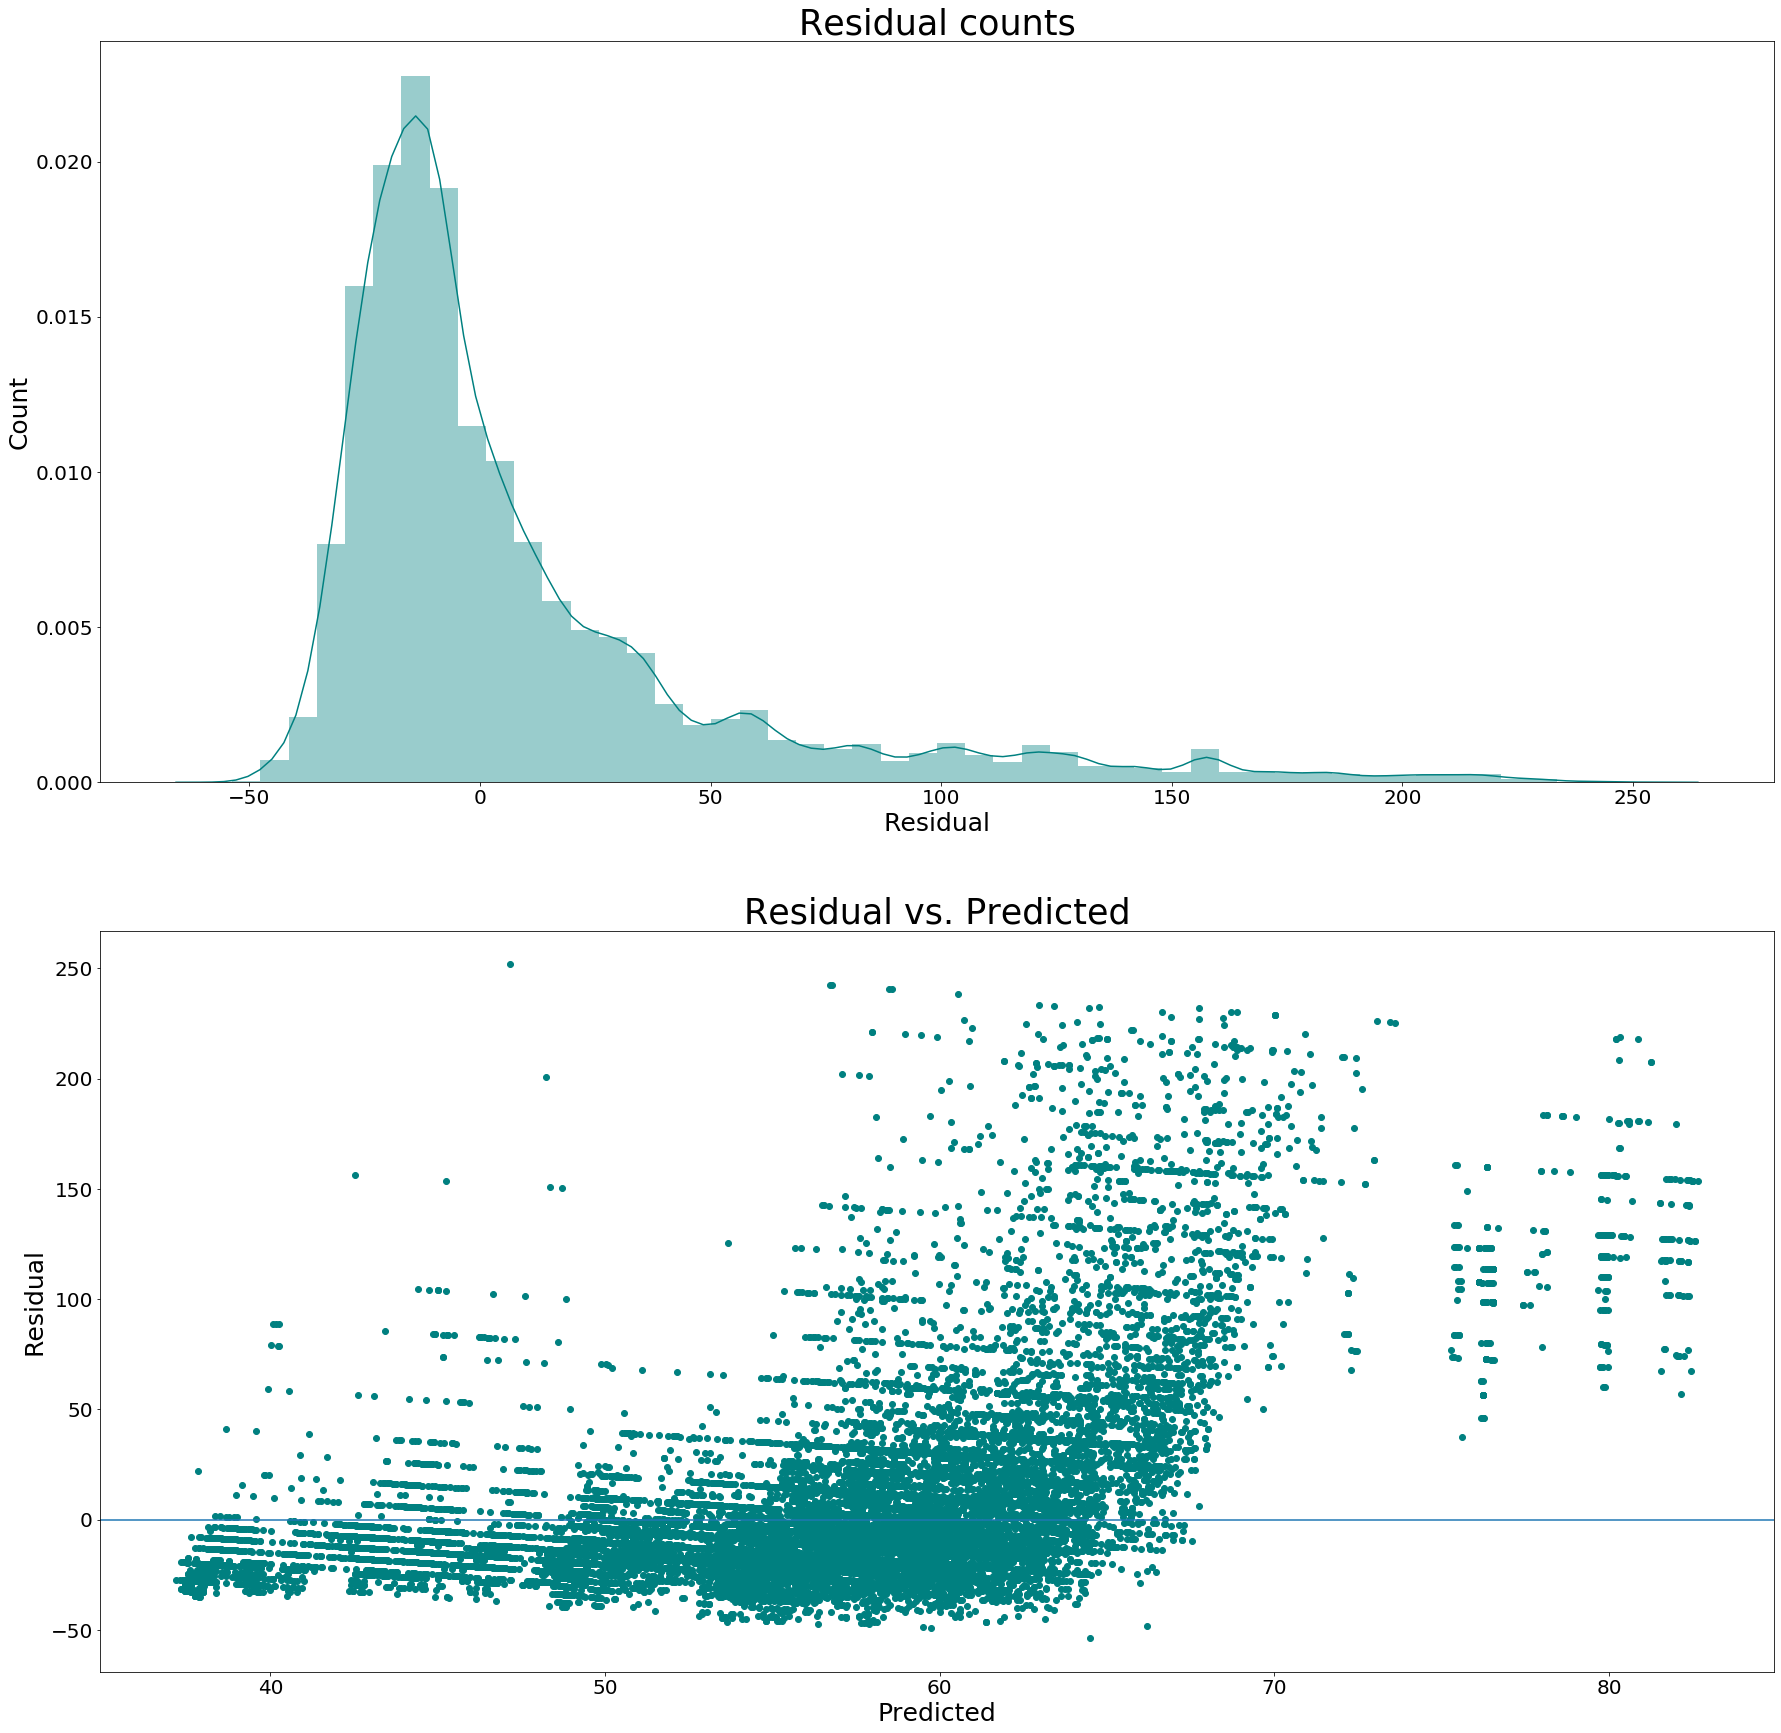

RMSE:
46.67653141185657


In [706]:
predicted = ridge_sc.predict(X_test)
residual = y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print('RMSE:')
print(rmse)

#### Modelling: KNN

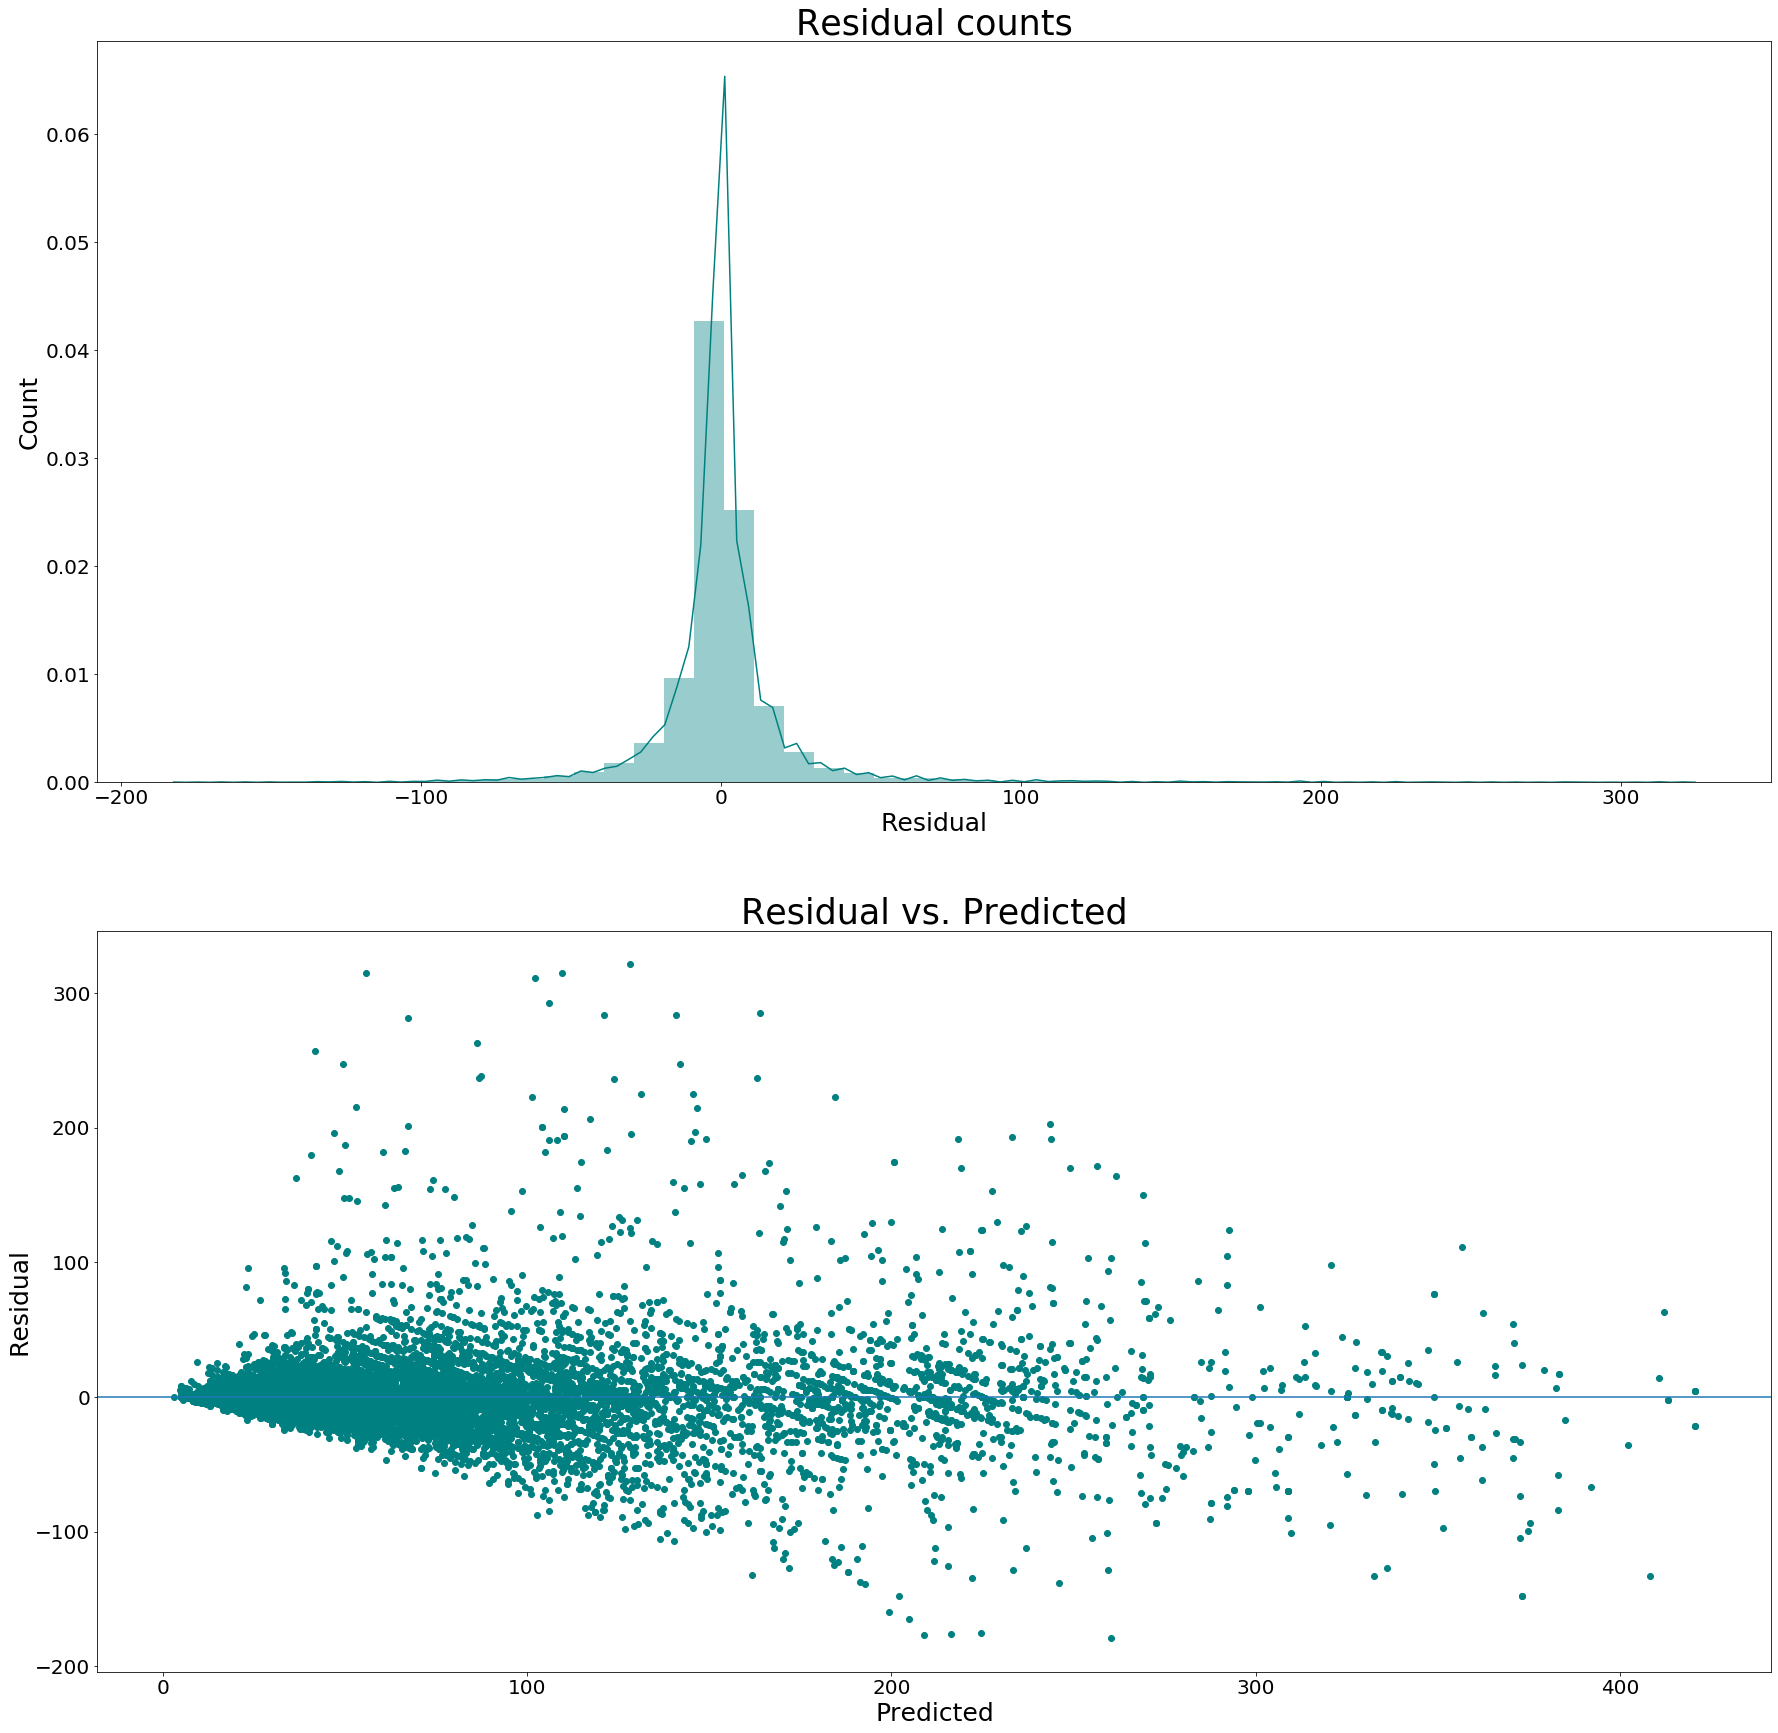

RMSE:
23.636489516978937


In [359]:

from sklearn import neighbors
# the value of n_neighbors will be changed when we plot the histogram showing the lowest RMSE value
knn = neighbors.KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, y_train)

predicted = knn.predict(X_test)
residual = y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted))
print('RMSE:')
print(rmse)


In [361]:
print('Variance score: %.2f' % r2_score(y_test, predicted))

Variance score: 0.83


## Gradient Boosting

In [705]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbr = GradientBoostingRegressor(loss ='ls', max_depth=6)
gbr.fit(X_train, y_train)
predicted = gbr.predict(y_test)
residual = y_test - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

rmse = np.sqrt(mean_squared_error(y_test, predicted))
scores = cross_val_score(gbr, X, y, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

ValueError: Expected 2D array, got 1D array instead:
array=[ 24.9   56.9  183.75 ...  92.9   24.99  74.11].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## 4. Choosing final model

In [721]:
df = pd.read_csv("clean_dataset.csv")

df.drop(columns=['Unnamed: 0'], inplace=True)

df.columns

df['text'] = df['title'] + ' ' + df['description']

df.drop(columns=['title','description','colour'], inplace= True)

In [722]:
features = [x for x in df.columns if (x!= 'price') ]

X = df[features]
y= df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [723]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

In [749]:
# imputer = make_column_transformer(
# (make_pipeline(SimpleImputer(strategy='missing',fill_value='missing'), 'brand'),
# (make_pipeline(SimpleImputer(strategy='missing',fill_value='missing'), 'category'),
#     (make_pipeline(SimpleImputer(strategy='missing',fill_value='missing'), 'text'),
#     )

In [ ]:


# categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),("onehot", OneHotEncoder(handle_unknown = 'ignore'))])

# preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer,numeric),("cat",categorial_transformer, cat )])


In [743]:
preprocess = make_column_transformer(
    ('brand', CountVectorizer(max_features=2000)),
     ('category', CountVectorizer(max_features=2000)),
    ('text', TfidfVectorizer(max_features=2000,ngram_range=(1, 3), stop_words='english'))
)

/Users/lynn/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:751: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


In [748]:
preprocess.fit_transform(X_train)

<54845x2746 sparse matrix of type '<class 'numpy.float64'>'
	with 1856943 stored elements in Compressed Sparse Row format>

In [726]:
X_train.head()

,brand,category,text
60307,h&m,jeans,"girlfriend regular jeans 5 pocket, ankle length jeans in washed stretch denim. slightly looser fit with a regular waist and zip fly with button. slightly dropped gusset and tapered legs with raw edge hems. cotton 99%, elastane 1%"
8243,mango,skirts,plaid mini skirt plaid print waist belt mini skirt sizing runs one size larger lined mid rise regular fit waist belt fastening 2 front side pockets cotton blend
49411,lipsy,outerwear,"lipsy knitted jumper with gold button detail in black worth making plans for ribbed finish high neck button detail long sleeves regular fit just select your usual size lightweight knit the kind that stretches fabric: 70% viscose, 30% polyamide."
40897,banana republic,tops,inverted v-neck blouse patterned print rounded hem top v neckline unlined regular fit polyester
15024,zalora,dresses,pleat detailed sheath dress side pleat detail sheath dress high neckline unlined regular fit back zip fastening polyester


In [727]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(imputer,preprocess, neighbors.KNeighborsRegressor(n_neighbors=6))

In [728]:
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('countvectorizer-1',
                                                  CountVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.int64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
           

In [729]:
model.score(X_test,y_test)

0.8530112192920029

In [730]:
from sklearn.externals import joblib
joblib.dump(model,"model.pkl")

['model.pkl']

In [680]:
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocess, GradientBoostingRegressor(loss ='ls', max_depth=6))

In [681]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.7554235722182594

In [682]:
model = make_pipeline(preprocess, Ridge())

In [683]:
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8582834418529413

### Attempting to Predict

In [731]:
user_input = {'category':'tops', 'brand':'forever new', 'text':'great silhouette, runs true to size'}

In [786]:
data = [['tops','forever new','great silhouette, runs true to size'],
        ['bottoms','nike','leggings with motif detail'],
        ['bottoms','adidas','leggings with motif detail'],
        ['dress','asos design','lace and sequins pink ribbon'],
        ['dress','h&m', 'lace and sequins pink ribbon'],
        ['dress','zara','lace and sequins pink ribbon']
       ]

In [787]:
df = pd.DataFrame(data, columns = ['category', 'brand','text']) 

In [788]:
df

,category,brand,text
0,tops,forever new,"great silhouette, runs true to size"
1,bottoms,nike,leggings with motif detail
2,bottoms,adidas,leggings with motif detail
3,dress,asos design,lace and sequins pink ribbon
4,dress,h&m,lace and sequins pink ribbon
5,dress,zara,lace and sequins pink ribbon


In [789]:
df['price']=model.predict(df)

In [790]:
df 

,category,brand,text,price
0,tops,forever new,"great silhouette, runs true to size",89.990000
1,bottoms,nike,leggings with motif detail,73.915000
2,bottoms,adidas,leggings with motif detail,78.615000
3,dress,asos design,lace and sequins pink ribbon,72.346667
4,dress,h&m,lace and sequins pink ribbon,21.323333
5,dress,zara,lace and sequins pink ribbon,49.566667
